In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
q_t1 = np.load("target_1.npy") # \in \mathcal{R}^{2}
print(q_t1.shape)
q_t2 = np.load("target_2.npy") #\in \mathcal{R}^{2}
print(q_t2.shape)

(2, 60)
(2, 60)


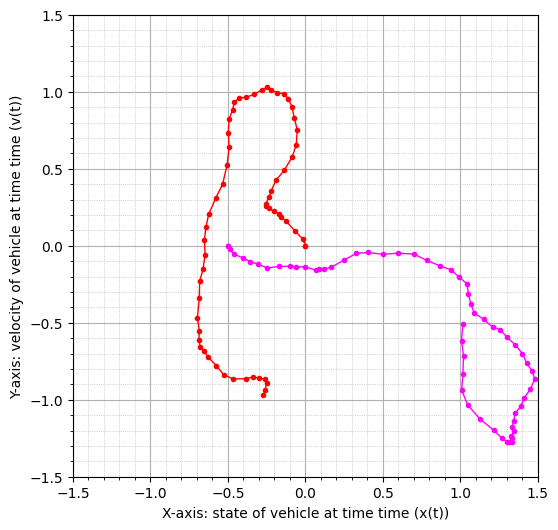

In [3]:
plt.figure(figsize=(6, 6))
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.plot(q_t1[0,:], q_t1[1,:], linewidth=1, color='red', linestyle='-')
plt.plot(q_t1[0,:], q_t1[1,:], 'o', color='red', markersize=3)
plt.plot(q_t2[0,:], q_t2[1,:], linewidth=1, color='magenta', linestyle='-')
plt.plot(q_t2[0,:], q_t2[1,:], 'o', color='magenta', markersize=3)
plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)      
plt.grid(which='minor', linestyle=':', linewidth=0.5)   
plt.xlabel('X-axis: state of vehicle at time time (x(t))')
plt.ylabel('Y-axis: velocity of vehicle at time time (v(t))') 
plt.show()

In [69]:
T = 60        # number of time steps
n = 4         # state dimension (p in R^2, v in R^2)

# State trajectory variable: shape (n, T)
x1 = cp.Variable((n, T))
x2 = cp.Variable((n, T))
x_1 = np.zeros((n, T))  # reference trajectory variable: shape (n, T)
u_1 = np.zeros((2, T-1))  # reference control input variable: shape (n), T-1)
x_2 = np.zeros((n, T))  # reference trajectory variable: shape (n, T)
u_2 = np.zeros((2, T-1))  # reference control input variable: shape (n), T-1)

u1 = cp.Variable((2, T-1))  # control input variable: shape (2, T-1)
u2 = cp.Variable((2, T-1))  # control input variable: shape (2, T-1)



E = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])  # matrix to extract position from state

A = np.array([[1, 0, 0.1, 0],
                [0, 1, 0, 0.1],
                [0, 0, 0.8, 0],
                [0, 0, 0, 0.8]])  # state transition matrix

B = np.array([[0, 0],
              [0, 0],
              [0.1, 0],
              [0, 0.1]])  # control input matrix

In [118]:
# Initial state constraint
TE_1 = cp.sum([cp.norm(E @ x1[:, t] - q_t1[:, t], 2) for t in range(T)])
TE_2 = cp.sum([cp.norm(E @ x2[:, t] - q_t2[:, t], 2) for t in range(T)])
CE_1 = cp.sum([cp.sum_squares(u1[:, t]) for t in range(T-1)])
CE_2 = cp.sum([cp.sum_squares(u2[:, t]) for t in range(T-1)])


def cost_function(TE_1, TE_2, p1=0.4, p2=0.6, rho = 0.1):
    J = p1 * (TE_1 + rho * CE_1) + p2 * (TE_2 + rho * CE_2)

    objectives = cp.Minimize(J)
    
    return objectives

In [119]:
constraints = []
for t in range(T-1):
    constraints += [x1[:, t+1] == A @ x1[:, t] + B @ u1[:, t]]  # dynamics constraints
    constraints += [x2[:, t+1] == A @ x2[:, t] + B @ u2[:, t]]  # dynamics constraints
# Initial condition
constraints += [x1[:, 0] == np.array([0.5, 0, 1, -1])]  # starting at origin with zero velocity
constraints += [x2[:, 0] == np.array([0.5, 0, 1, -1])]  # starting at origin with zero velocity

# Common control before t = 25
constraints += [u1[:, 0:24] == u2[:, 0:24]]

In [120]:
objectives = cost_function(TE_1, TE_2)
prob = cp.Problem(objectives, constraints)
time_start = time.time()
result = prob.solve()
time_end = time.time()
print("Optimal value: ", result)
print("Solve time: ", time_end - time_start)

Optimal value:  38.49888108551817
Solve time:  0.3920319080352783


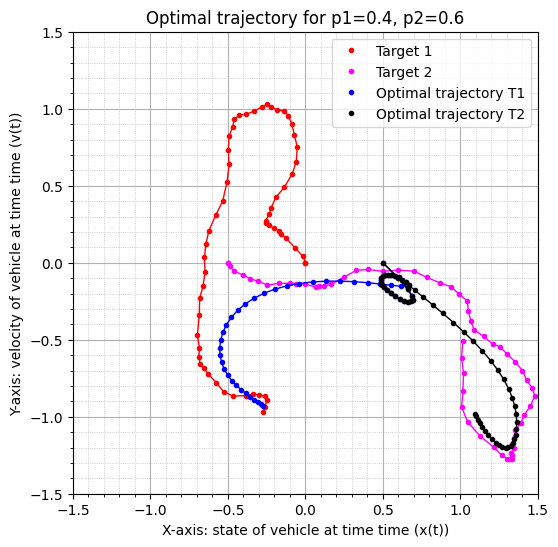

In [122]:
# Extract solutions
x1_val = x1.value
x2_val = x2.value

plt.figure(figsize=(6, 6))  
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.plot(q_t1[0,:], q_t1[1,:], linewidth=1, color='red', linestyle='-')
plt.plot(q_t1[0,:], q_t1[1,:], 'o', color='red', markersize=3, label='Target 1')
plt.plot(q_t2[0,:], q_t2[1,:], linewidth=1, color='magenta', linestyle='-')
plt.plot(q_t2[0,:], q_t2[1,:], 'o', color='magenta', markersize=3, label='Target 2')
plt.plot(x1_val[0,:], x1_val[1,:], linewidth=1, color='blue', linestyle='-')
plt.plot(x1_val[0,:], x1_val[1,:], 'o', color='blue', markersize=3, label='Optimal trajectory T1')
plt.plot(x2_val[0,:], x2_val[1,:], linewidth=1, color='black', linestyle='-')
plt.plot(x2_val[0,:], x2_val[1,:], 'o', color='black', markersize=3, label='Optimal trajectory T2')
plt.legend()
plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)      
plt.grid(which='minor', linestyle=':', linewidth=0.5)   
plt.xlabel('X-axis: state of vehicle at time time (x(t))')
plt.ylabel('Y-axis: velocity of vehicle at time time (v(t))') 
plt.title('Optimal trajectory for p1=0.4, p2=0.6')
plt.show()  